# 引入库

In [1]:
import keras
import os
import json
import shutil
from keras import layers
from keras import models
from keras import optimizers
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
import matplotlib.pyplot as plt
import numpy as np
from keras import backend as K
from mylibs.ProcessBar import ShowProcess
from mylibs import funs
from mylibs.my_contrib import *
keras.__version__

Using TensorFlow backend.


'2.2.4'

# 猫狗分类实验
## 实验目的
创建一个简单图像二分类的卷积模型,掌握以下知识点：
* 数据生成器的使用方法
    ./MyDL/Tensorflow/demo/python/demo_ImageDataGenerator2.py
* 卷积神经网络模型创建：卷积层，密度层，激活函数，损失函数，优化函数
* 模型训练方法
* 模型预测方法
* plt基本使用方法
* 训练曲线绘制
* 可视化FeatureMap
* 可视化神经网络的过滤器
* 可视化类激活的热力图

本实验的数据将作为基础参考

## 实验数据说明
  * 网络数据下载地址：https://www.kaggle.com/c/dogs-vs-cats/data
  * 本地数据存储路径：~/e/dataset_tiptical/cats_and_dogs
  * 实验数据根目录：~/data/cats_and_dogs
      - ./ori      ------------猫狗分类原始数据目录
      - ./lab_base ------------实验方案目录
      - ./lab_base/train ------训练目录
      - ./lab_base/valid ------校验目录
      - ./lab_base/test  ------测试目录
      - ./lab_base/test.jpg ---测试图片
      

## 参考资料
visualization of filters keras 基于Keras的卷积神经网络（CNN）可视化

http://www.cnblogs.com/bnuvincent/p/9612686.html

python深度学习{eep learning with python中文版.pdf}源码

https://github.com/fchollet/deep-learning-with-python-notebooks

数据下载：

https://www.kaggle.com/c/dogs-vs-cats/data

本地数据

~/e/dataset_tiptical/cats_and_dogs


# 实验4
VGG19预训练模型提取特征

## 实验参数

In [2]:
##实验参数
print('\n==============================================')
print('设置实验参数')
lab_name='猫狗分类实验-VGG16预训练模型调参'              #实验名称
data_path='%s/data/cats_and_dogs'%(os.getenv('HOME')) #猫狗分类数据根目录
ori_path='%s/ori'%(data_path)                         #猫狗分类原始文件目录
lab_path='%s/lab_vgg19_fine_tuning'%(data_path)          #实验方案目录
split_num="10000,2000,2000"                           #实验数据分割方案,<1：比例分割，>1：数量分割
batch_size=32                                         #批量大小
data_enhance=False                                    #ImageDataGenerator数据启用数据增强
epochs=10                                             #训练轮次
img_width=224                                         #训练图像宽度
img_height=224                                        #训练图像高度 
test_img_path='%s/test.jpg'%(data_path)               #测试图片路径
images_per_row=16       #图像显示每行显示的单元个数
#feature_map_top_num=12  #FeatureMap前面N层{include_top=False}
img_margin=3            #图像单元空隙
layers_name=['conv2d_1','conv2d_2','conv2d_3','conv2d_4'] #卷积层名称
#layers_name=['conv2d_1'] #卷积层名称
last_conv_layer_name='conv2d_4' #最后一层卷积层
gen_pat_steps=40                           #构造迭代次数
cp_file='%s/checkpoint.h5'%(lab_path)      #ModelCheckpoint 文件路径
his_file='%s/history.json'%(lab_path)      #训练日志文件路径
class_mode='binary'                        #分类方法,'binary':二分类，'categorical':多分类
loss='binary_crossentropy'  #损失函数,'binary_crossentropy':二分类，'categorical_crossentropy':多分类

test_cat_path='%s/test_cat.jpg'%(data_path) #猫的测试图像
test_dog_path='%s/test_dog.jpg'%(data_path) #狗的测试图像


设置实验参数


## 加载数据

In [3]:
##加载数据
print('\n==============================================')
print('加载数据......')
#删除lab_path
#shutil.rmtree(lab_path) if os.path.exists(lab_path) else ''

#数据生成器
(train_gen,valid_gen,test_gen)=DataGen(ori_path,lab_path,reset=True,split_num=split_num
                                   ,img_width=img_width,img_height=img_height
                                   ,batch_size=batch_size,enhance=data_enhance,class_mode=class_mode)


加载数据......
img_width:224
batch_size:32
reset:True
class_mode:binary
split_num:10000,2000,2000
enhance:False
img_height:224
delete folder:/home/hjw/data/cats_and_dogs/lab_vgg19_fine_tuning
imgages_split:/home/hjw/data/cats_and_dogs/ori=>/home/hjw/data/cats_and_dogs/lab_vgg19_fine_tuning
Found 20000 images belonging to 2 classes.
Found 4000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


## 创建网络

In [4]:
print('\n==============================================')
print('构建网络')
from keras.applications import VGG19
## 创建网络
model_vgg19=VGG19(weights='imagenet',include_top=False,input_shape=(224, 224, 3))

'''
for layer in model_vgg19.layers:
    layer.trainable=False
'''

set_trainable = False
for layer in model_vgg19.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False


model_vgg19.summary()

model = models.Sequential()
model.add(model_vgg19)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))
#打印模型
model.summary()
#模型编译
model.compile(loss=loss,
          optimizer=optimizers.RMSprop(lr=1e-4),
          metrics=['acc'])


构建网络
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
____

## 网络训练

In [5]:
class train_callback(keras.callbacks.Callback):
    def __init__(self,log_file,history={},verbose=0):
        super(train_callback,self).__init__() #调用父类构造函数
        self.log_file=log_file #训练日志文件路径
        self.history=history   #训练日志
        self.verbose=verbose   #是否显示保存信息
        
    #on_epoch_end: 在每个epoch结束时调用
    def on_epoch_end(self,epoch,logs=None):
        #最佳日志
        if len(self.history)==0:
            for k,v in logs.items():
                self.history[k]=[v]
        else:
            for k,v in logs.items():
                self.history[k].append(v)
        #保存日志
        json.dump(self.history,open(self.log_file,'w'))
        if self.verbose==1:
            print('更新训练日志(%d):%s'%(len(self.history),self.log_file))

In [6]:
##网络训练
print('\n==============================================')
print('网络训练 ......')
#加载断点
if os.path.exists(cp_file):
    model.load_weights(cp_file)
    print('加载模型文件:',cp_file)
#训练日志
history2={}
if os.path.exists(his_file):
    history2=json.load(open(his_file,'r'))
    print('加载训练日志:',his_file)


网络训练 ......


In [7]:
#回调函数保存训练日志    
his_cb=train_callback(his_file,history=history2)

#断点训练:monitor监控参数可以通过self.score = self.model.evaluate(self.x_test, self.y_test, verbose=0)的score查询
checkpoint_cb = ModelCheckpoint(cp_file, monitor='val_acc', verbose=1, save_best_only=True, mode='auto',period=2)
#EarlyStopping
earlyStopping_cb=keras.callbacks.EarlyStopping(monitor='acc', patience=3, verbose=0, mode='max')
#TensorBoard
#tensorBoard_cb=TensorBoard(log_dir=self.log_dir)
#回调函数序列
callbacks_list = [checkpoint_cb,earlyStopping_cb,his_cb]

history = model.fit_generator(
  train_gen,
  steps_per_epoch=np.ceil(train_gen.samples/batch_size),
  epochs=epochs,
  validation_data=valid_gen,
  validation_steps=50,
  callbacks=callbacks_list)

Epoch 1/10
625/625 [==============================] - 95s 152ms/step - loss: 0.2403 - acc: 0.9052 - val_loss: 0.1745 - val_acc: 0.9381
Epoch 2/10
625/625 [==============================] - 93s 149ms/step - loss: 0.1244 - acc: 0.9555 - val_loss: 0.1645 - val_acc: 0.9544

Epoch 00002: val_acc improved from -inf to 0.95437, saving model to /home/hjw/data/cats_and_dogs/lab_vgg19_fine_tuning/checkpoint.h5
Epoch 3/10
625/625 [==============================] - 93s 149ms/step - loss: 0.1126 - acc: 0.9637 - val_loss: 0.1465 - val_acc: 0.9381
Epoch 4/10
625/625 [==============================] - 93s 149ms/step - loss: 0.0998 - acc: 0.9735 - val_loss: 0.1440 - val_acc: 0.9525

Epoch 00004: val_acc did not improve from 0.95437
Epoch 5/10
625/625 [==============================] - 93s 149ms/step - loss: 0.0880 - acc: 0.9757 - val_loss: 0.1299 - val_acc: 0.9625
Epoch 6/10
625/625 [==============================] - 93s 148ms/step - loss: 0.1089 - acc: 0.9796 - val_loss: 0.2733 - val_acc: 0.9494

Epoc

## 保存模型

In [8]:
##保存模型
print('\n==============================================')
print('保存模型 ......') 
save_model(model,lab_path,train_gen.class_indices)


保存模型 ......


# 测试简报

In [9]:
score_valid = model.evaluate_generator(valid_gen, steps=100, max_q_size=10, workers=1, pickle_safe=False,verbose=1)

  1/100 [..............................] - ETA: 18s

/home/hjw/.local/lib/python3.5/site-packages/ipykernel_launcher.py:1: UserWarning: Update your `evaluate_generator` call to the Keras 2 API: `evaluate_generator(<keras_pre..., steps=100, max_queue_size=10, verbose=1, workers=1, use_multiprocessing=False)`
  """Entry point for launching an IPython kernel.


100/100 [==============================] - 12s 118ms/step


In [10]:
preds=model.predict_generator(
    test_gen, 
    steps=None, #预测轮数
    max_queue_size=32, 
    workers=1, 
    use_multiprocessing=False,     
    verbose=1)
print(valid_gen.samples)

32/32 [==============================] - 4s 127ms/step
4000


In [11]:
preds_acc_val=preds_acc(preds,test_gen)

In [12]:
print('\n\n')
print('================测试简报(%s[%s])=================='%(lab_name,lab_path))
#网络模型
print('VGG19')
print(['%s:%s'%(layer.name,'True' if layer.trainable else 'False') for layer in model_vgg19.layers])
model_vgg19.summary()
model.summary()
#网络输入
print('input_shape:%s'%(model.input.shape))
#网络训练
print('train=>epochs :%d,samples:%d,loss:%f,acc:%f'
          %(epochs,len(train_gen.filenames),history.history['loss'][-1],history.history['acc'][-1]))
#网络评估
print('valid=>samples:%d,val_loss:%f,val_acc:%f'%(len(valid_gen.filenames),score_valid[0],score_valid[1]))
#网络测试
print('test =>samples:%d,acc:%f'%(len(test_gen.filenames),preds_acc_val))




================测试简报(猫狗分类实验-VGG16预训练模型调参[/home/hjw/data/cats_and_dogs/lab_vgg19_fine_tuning])==================
VGG19
['input_1:False', 'block1_conv1:False', 'block1_conv2:False', 'block1_pool:False', 'block2_conv1:False', 'block2_conv2:False', 'block2_pool:False', 'block3_conv1:False', 'block3_conv2:False', 'block3_conv3:False', 'block3_conv4:False', 'block3_pool:False', 'block4_conv1:False', 'block4_conv2:False', 'block4_conv3:False', 'block4_conv4:False', 'block4_pool:False', 'block5_conv1:True', 'block5_conv2:True', 'block5_conv3:True', 'block5_conv4:True', 'block5_pool:True']
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 

## 网络测试

[[0.]]
[[0.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/cat/cat.14.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test_small/cat/cat.14.jpg'}


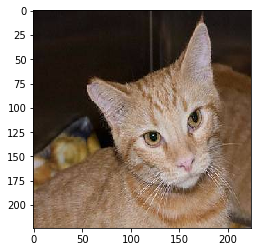

[[0.]]
[[0.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/cat/cat.109.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test_small/cat/cat.109.jpg'}


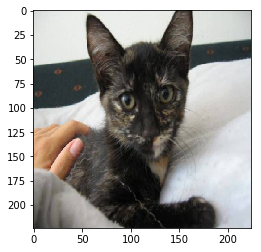

[[0.]]
[[0.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/cat/cat.104.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test_small/cat/cat.104.jpg'}


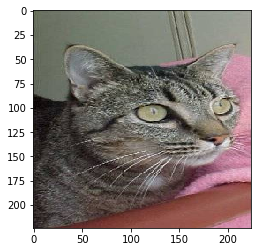

[[0.]]
[[0.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/cat/cat.16.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test_small/cat/cat.16.jpg'}


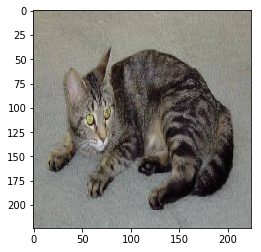

[[0.]]
[[0.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/cat/cat.66.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test_small/cat/cat.66.jpg'}


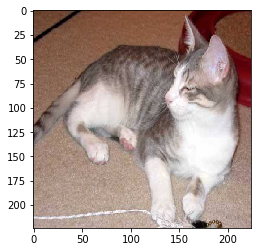

[[0.]]
[[0.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/cat/cat.75.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test_small/cat/cat.75.jpg'}


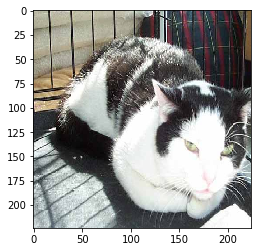

[[0.]]
[[0.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/dog/dog.203.jpg']
[0]
Predicted: {0: 'cat,/home/hjw/data/cats_and_dogs/test_small/dog/dog.203.jpg'}


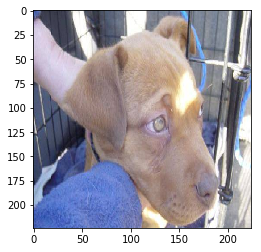

[[1.]]
[[1.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/dog/dog.146.jpg']
[1]
Predicted: {1: 'dog,/home/hjw/data/cats_and_dogs/test_small/dog/dog.146.jpg'}


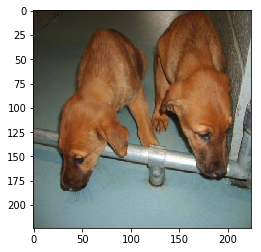

[[1.]]
[[1.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/dog/dog.267.jpg']
[1]
Predicted: {1: 'dog,/home/hjw/data/cats_and_dogs/test_small/dog/dog.267.jpg'}


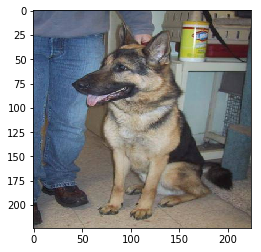

[[1.]]
[[1.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/dog/dog.274.jpg']
[1]
Predicted: {1: 'dog,/home/hjw/data/cats_and_dogs/test_small/dog/dog.274.jpg'}


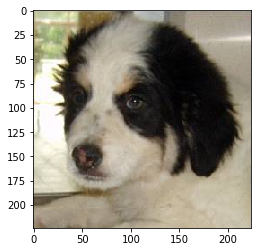

[[1.]]
[[1.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/dog/dog.196.jpg']
[1]
Predicted: {1: 'dog,/home/hjw/data/cats_and_dogs/test_small/dog/dog.196.jpg'}


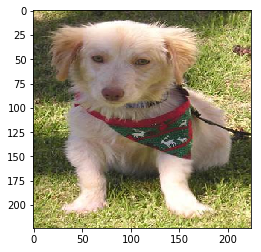

[[1.]]
[[1.]]
{0: 'cat', 1: 'dog'}
['/home/hjw/data/cats_and_dogs/test_small/dog/dog.155.jpg']
[1]
Predicted: {1: 'dog,/home/hjw/data/cats_and_dogs/test_small/dog/dog.155.jpg'}


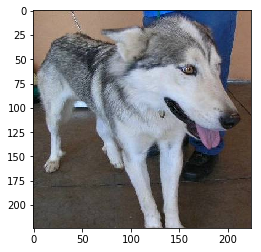

{}

In [13]:
images=[]
funs.GatherFilesEx('%s/test_small'%(data_path),images,exts='.jpg,.jpeg')
predict_images(model,images,train_gen.class_indices,img_width=img_width,img_height=img_height)

## 训练曲线


训练曲线


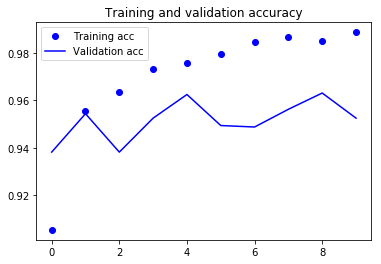

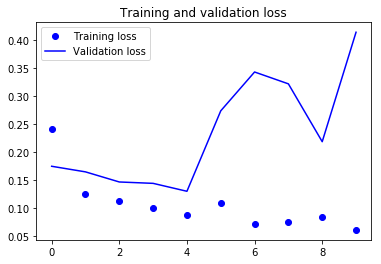

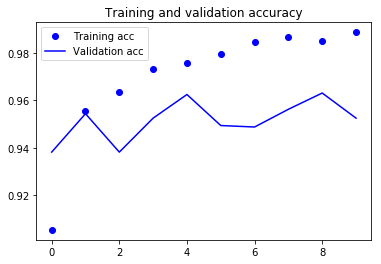

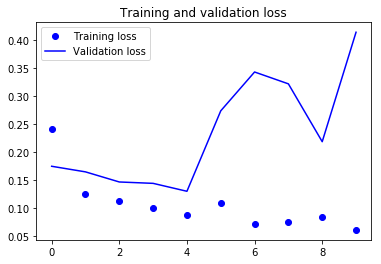

In [14]:
##训练曲线
print('\n==============================================')
print('训练曲线')
visualizer_scalar(history.history)
visualizer_scalar(history2)

## 可视化FeatureMap

In [15]:
##可视化FeatureMap
print('\n==============================================')
print('可视化FeatureMap-猫')
#visualizer_feature_map(model,test_cat_path,target_size=(img_height,img_width)
#                       ,images_per_row=images_per_row,img_margin=img_margin)


可视化FeatureMap-猫


In [16]:
print('可视化FeatureMap-狗')
#visualizer_feature_map(model,test_dog_path,target_size=(img_height,img_width)
#                       ,images_per_row=images_per_row,img_margin=img_margin)

可视化FeatureMap-狗


## 可视化类激活热力图

In [17]:
##可视化类激活热力图
print('可视化类激活热力图-猫')
#visualizer_heatmap(model,test_cat_path,last_conv_layer_name,target_size=(img_height,img_width))

可视化类激活热力图-猫


In [18]:
##可视化类激活热力图
print('可视化类激活热力图-狗')
#visualizer_heatmap(model,test_dog_path,last_conv_layer_name,target_size=(img_height,img_width))

可视化类激活热力图-狗


## 可视化网络过滤器

In [19]:
##可视化网络过滤器
print('\n==============================================')
print('可视化网络过滤器')
#visualizer_filter_input(model,layers_name,gen_pat_steps=gen_pat_steps,images_per_row=images_per_row
#                        ,img_width=img_width,img_height=img_height,img_margin=img_margin)


可视化网络过滤器
